In [83]:
import os
import math
import random
import operator
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from operator import itemgetter

In [84]:
current_dir = os.getcwd()
df = pd.read_csv(current_dir + '/exercise2_data.csv', delimiter=",")

In [85]:
df.head(5)

,account_no,gender,age,income,loan_amount,term,installment_amount,interest_rate,credit_score_at_application,outstanding_balance,status
0,acc_00000316,F,18,12143,47000,60,1045,0.12,860,0,PAID_UP
1,acc_00000422,F,18,6021,13000,60,330,0.18,640,0,PAID_UP
2,acc_00001373,F,39,12832,13000,60,296,0.13,820,0,PAID_UP
3,acc_00001686,F,33,4867,5000,36,191,0.22,540,0,PAID_UP
4,acc_00001733,F,23,5107,22000,36,818,0.20,580,11314,LIVE
5,acc_00002114,M,38,9328,25000,36,904,0.18,630,0,PAID_UP
6,acc_00002270,F,18,5763,15000,60,381,0.18,630,0,PAID_UP
7,acc_00002927,M,42,12762,24000,48,668,0.15,730,0,PAID_UP
8,acc_00003222,M,43,6718,16000,48,522,0.24,520,2923,DEFAULT
9,acc_00006967,F,38,9662,17000,48,482,0.16,720,0,PAID_UP


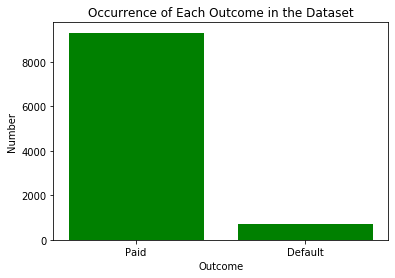

In [86]:
x = ['Paid', 'Default']
count = [len(df.query('status == "PAID_UP"')), len(df.query('status == "DEFAULT"'))]
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, count, color='green')
plt.xlabel("Outcome")
plt.ylabel("Number")
plt.title("Occurrence of Each Outcome in the Dataset")
plt.xticks(x_pos, x)
plt.show()

The dataset is highly imblanced.
Learning on this would be difficult since the model would be biased to the majority class (persons who paid out their loan).

In [87]:
# Encoding the values of the gender column.
le = LabelEncoder()
le.fit(df.gender.unique())
print(list(le.classes_))
df.gender = le.transform(df.gender)

['F', 'M']


In [112]:
# For simplicity, replace all occurrences of the target variable with either: y - defaulted, n - did not default.
df = df.replace({'status': {'PAID_UP': 'n', 'DEFAULT': 'y'}})
# Seprate dataset into training set and live testing set.
df_filtered_hist = df.query('(status == "n" | status == "y")')
df_filtered_live_old = df.query('(status == "LIVE")')
df_filtered_live_y = df_filtered_live_old.status
df_filtered_live = df_filtered_live_old.drop(columns = ['account_no', 'outstanding_balance', 'status'])
print(df_filtered_hist.shape)
print(df_filtered_live.shape)

(9997, 11)
(2001, 8)


In [89]:
# Before we begin training of the model, we need to remove some unwanted columns.
x = df_filtered_hist.drop(columns = ['account_no', 'outstanding_balance', 'status'])
# x = x.drop(columns = ['gender', 'loan_amount', 'term', 'installment_amount'])
y = df_filtered_hist.status
print(y[100])
le = LabelEncoder()
le.fit(y.unique())
y = le.transform(y)
print(y[100])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

n
0


In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, recall_score

logisticRegr = LogisticRegression(penalty='l1', tol= 1e-5, solver='liblinear')
logisticRegr.fit(x_train, y_train)
pred = logisticRegr.predict(x_test)
pred_prob = logisticRegr.predict_proba(x_test)
print(logisticRegr.score(x_test, y_test))
print(f1_score(y_test, pred))
print(roc_auc_score(y_test, pred_prob[:,1]))
print(confusion_matrix(y_test, pred))

0.971
0.7716535433070866
0.9890765620163695
[[1844   19]
 [  39   98]]


The mean accuracy reveals that the model is working almost perfect.
However, this is contradicted by the F1 and AUC scores as well as the confusion matrix.
The ROC metric would appear to be good but the bias in the dataset falisfies this.
We have the options of using either undersampling or oversampling techniques.
Both techniques have drawbacks so we resort to using a new classifier.
Our new choice is the decision tree.

In [138]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10).fit(x_train, y_train)

# predict on test set
rfc_pred = rfc.predict(x_test)
rfc_pred_prob = rfc.predict_proba(x_test)

print(accuracy_score(y_test, rfc_pred))
print(f1_score(y_test, rfc_pred))
print(roc_auc_score(y_test, rfc_pred_prob[:,1]))
print(confusion_matrix(y_test, rfc_pred))

0.984
0.8778625954198473
0.9831231315945164
[[1853   10]
 [  22  115]]


Results reveal that the decision tree handles the bias better than Logistic Regression.
We can now use this on the dataset we are required to do predictions on.
We have 87% accuracy.

In [139]:
rfc_prob = rfc.predict_proba(df_filtered_live)

In [147]:
sum_expected = 0.0
index = 0
for i in range(0, len(rfc_prob)):
    sum_expected += (rfc_prob[i,0]) * df_filtered_live_old.iloc[i].outstanding_balance
print(sum_expected)

2001
23801278.599999994
